#Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

# You may add any imports you need

In [ ]:
import albumentations

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
pip install --upgrade albumentations

In [ ]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# YOU CAN DEFINE AUGMENTATIONS HERE
# посмотрел записи с семинаров - попробую что-то смастерить
# https://github.com/albumentations-team/albumentations/issues/879 наткнулся на такое еще
# на страничке в гите посоветовали такой способ, чтобы аугментации из albumentations заработали

class Transformer:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):

        return self.transforms(image=np.array(img))["image"]

train_transform_1 = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.augmentations.transforms.Normalize(),
        ToTensorV2()
    ]
)
val_transform_1 = A.Compose(
     [
        A.augmentations.transforms.Normalize(),
        ToTensorV2()
     ]
)

In [ ]:
train_transform_1 = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.augmentations.transforms.Normalize(),
        ToTensorV2()
    ]
)
val_transform_1 = A.Compose(
     [
        A.augmentations.transforms.Normalize(),
        ToTensorV2()
     ]
)

In [ ]:
train_dataset_1 = ImageFolder('dataset/dataset/train', transform=Transformer(train_transform_1))
val_dataset_1 = ImageFolder('dataset/dataset/val', transform=Transformer(val_transform_1))

train_dataloader_1 = DataLoader(
    train_dataset_1,
    batch_size=128,
    shuffle=True,
    num_workers=2
)
val_dataloader_1 = DataLoader(
    val_dataset_1,
    batch_size=128,
    num_workers=2
)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

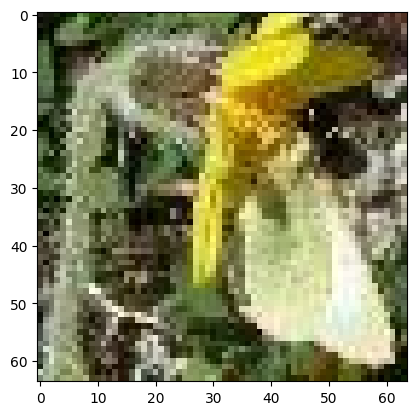

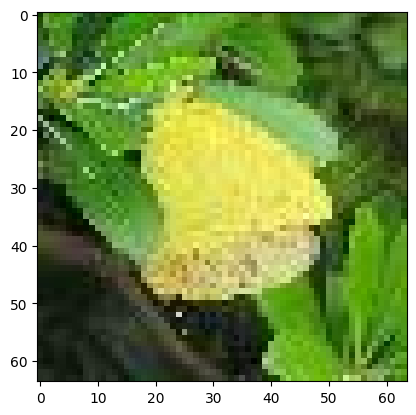

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

я хз что это (
  


## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torchvision.datasets import ImageFolder
import albumentations
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.loggers import WandbLogger

In [ ]:
#дальше пойдут служебные функции
#отрисую график

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

### Тренировочный класс lightning

In [ ]:
#что-то подобное было на семинарах - воспользуемся этим ужасом
def train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=5, target=0.44):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        #затреним нашего покемона
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(train_dataloader,
                                 desc=f"Training, epoch {epoch}",
                                 leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #log loss для текущей эпохи и всей истории обучения
            train_epoch_loss = torch.cat((train_epoch_loss,
                                          loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            #log accuracy  для текущей эпохи и всей истории обучения
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits,
                (pred_classes == labels.cpu()).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])


        #валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader,
                                     desc=f"Validating, epoch {epoch}",
                                     leave=False):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss,
                                            loss.cpu().unsqueeze(0) / labels.cpu().size(0)))

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0)
                ))


        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")
        if scheduler is not None:
            scheduler.step()
        acc = evaluate_task(model, val_dataloader)
        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )
        print("Acc: ", acc)
        if acc >= target:
            break

### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

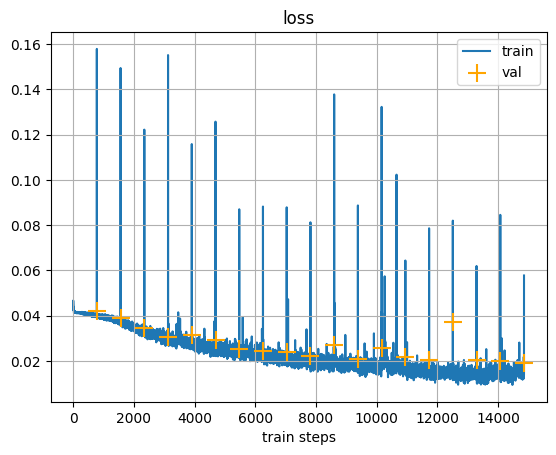

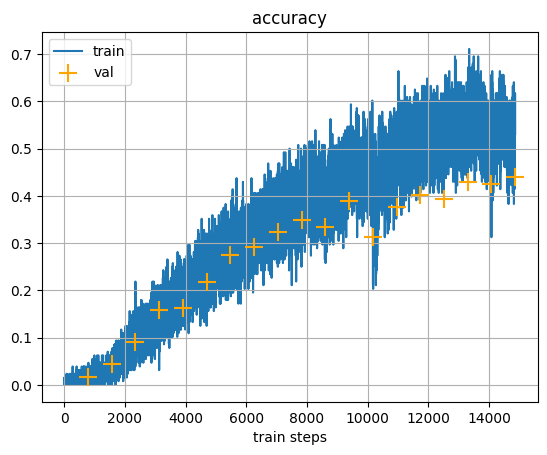

100%|██████████| 79/79 [00:06<00:00, 12.77it/s]


Train loss: 0.014526466839015484
Train acc: 0.5372542142868042
Val loss: 0.019255224615335464
Val acc: 0.43928006291389465
Acc:  0.4442


In [ ]:
model_1 = torchvision.models.vgg16_bn(weights=None, num_classes=200)
model_1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_1.parameters(),
    lr=0.02,
    momentum=0.905
)

scheduler_func = lambda epoch: 0.95 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)

train(model_1,
      criterion,
      optimizer,
      train_dataloader_1,
      val_dataloader_1,
      n_epochs=25)

In [ ]:
model = model_1

accuracy = evaluate_task(model, val_dataloader_1)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 79/79 [00:08<00:00,  9.40it/s]

Оценка за это задание составит 10.00 баллов


я считаю, это победа! в выводе поминутно распишу, кто и где


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
model = torchvision.models.efficientnet_b1(pretrained=True)
model.classifier[1] = nn.Linear(1280, 200)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.905
)

scheduler_func = lambda epoch_lr: 0.75 ** epoch_lr

scheduler = optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)


### Тренировочный класс lightning

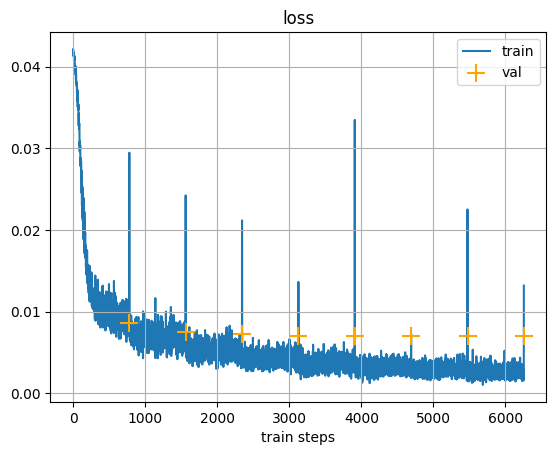

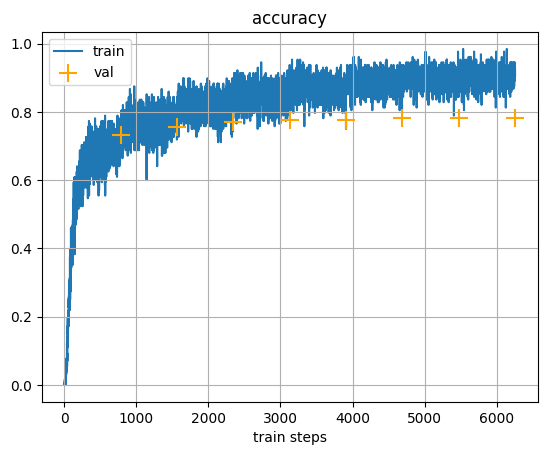

100%|██████████| 79/79 [00:10<00:00,  7.70it/s]


Train loss: 0.002700356300920248
Train acc: 0.9029331803321838
Val loss: 0.007050291635096073
Val acc: 0.7821400165557861
Acc:  0.7909


In [ ]:
train_transform_2 = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.augmentations.transforms.Normalize(),
        ToTensorV2()
    ]
)
val_transform_2 = A.Compose(
     [
        A.Resize(width=128, height=128),
        A.augmentations.transforms.Normalize(),
        ToTensorV2()
     ]
)

train_dataset_2 = ImageFolder('dataset/dataset/train', transform=Transformer(train_transform_2))
val_dataset_2 = ImageFolder('dataset/dataset/val', transform=Transformer(val_transform_2))

train_dataloader_2 = DataLoader(
    train_dataset_2,
    batch_size=128,
    shuffle=True,
    num_workers=2
)
val_dataloader_2 = DataLoader(
    val_dataset_2,
    batch_size=128,
    num_workers=2
)

train(model,
      criterion,
      optimizer,
      train_dataloader_2,
      val_dataloader_2,
      scheduler=scheduler,
      n_epochs=25,
      target=0.79)

### Валидация результатов задания

In [ ]:
model2 = model

accuracy = evaluate_task(model2, val_dataloader_2)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 79/79 [00:11<00:00,  6.75it/s]

Оценка за это задание составит 8.56 баллов


не как в первом задании конечно, но пойдет

# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

Перед этим увлекательным рассказом я бы хотел начать с причи

Однажды Учитель поставил чайник на огонь и забыл о нём. Чайник благополучно расплавился. Другой бы на месте Учителя расстроился, но разве Учитель позволит себе такую
глупость?

-Это знак, который послали мне небеса, - сказал сам себе Учитель. – Видимо, сегодня мне чай вреден.
И пошёл пить пиво.

Забавно, не правда ли? Это был единственный позитивный момент в этой домашке. Теперь перейдем к сути.

Задание 1

Работал с albumentations и выбрал подходящие аугментации. Решил начать с импорта готовой архитектуры модели (без весов). Просмотрел лекцию и начал с ResNet и оптимайзера AdaGrad, но результаты были так себе. Попробовал SGD с шагом 0.01 и моментумом около 0.9, и результаты стали радовать глаз (я даже слезу пустил). Достиг accuracy до 0.4 с ResNet и решил опробовать другие архитектуры. GoogleNet не подошёл, но VGG с 19 слоями был лучше. В итоге, с VGG 16 с batch norm получил результат 0.4442 где-то на 17-18 эпохе

Задание 2

Предобученные модели ResNet, GoogleNet и VGG показывали низкий accuracy - это меня ввело в тильт, так как до этого вроде справлялся норм, а тут гг. С шедулерами улучшил результаты  с ResNet. Изучил материалы про MobileNet и EfficientNet, решил их попробовать - в основном наш любимый хабр помог.

https://habr.com/ru/articles/352804/

https://habr.com/ru/articles/498168/

EfficientNet на первой эпохе достиг где-то 0.75 accuracy - я так знатно прибалдел! Но дальше не смог поднять выше 0.79. В итоге, остановился на accuracy 0.79
